In [1]:
# Core libraries for this tutorial
# Available via `pip install zarr zarr-eosdis-store`
from eosdis_store import EosdisStore
import xarray as xr

# Other Python libraries
import requests
from pqdm.threads import pqdm
from matplotlib import animation, pyplot as plt
from IPython.core.display import display, HTML

# Python standard library imports
from pprint import pprint
import numpy
import cartopy.crs as ccrs
import cartopy

#to make big figures
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
#select SSS L4: 
dataset='podaac-ops-cumulus-protected/OISSS_L4_multimission_7day_v1'
shortname='OISSS_L4_multimission_7day_v1'

#timeframe of interest:
start_date = '2015-08-01T00:00:00Z'
end_date   = '2015-10-31T23:59:59Z'

#region of interest:
lonmin = -170.0
latmin = 65.0
lonmax = -120.0
latmax = 80.0

In [3]:
plt.set_cmap(cmap=plt.get_cmap('turbo'))

<Figure size 864x432 with 0 Axes>

In [4]:
CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
url = f'{CMR_OPS}/{"collections"}'

In [5]:
provider = 'POCLOUD'
response = requests.get(url,
                        params={
                            'cloud_hosted': 'True',
                            'has_granules': 'True',
                            'provider': provider,
                            'page_size': 251,
                        },
                        headers={
                            'Accept': 'application/json'
                        }
                       )

In [6]:
response.headers['cmr-hits']

'251'

In [7]:
#to find the concept ID and/or shortname
collections = response.json()['feed']['entry']
# for collection in collections:
#     print(f'{collection["archive_center"]} {collection["dataset_id"]} {collection["id"]}')
#OR
# provider = 'POCLOUD'
# response = requests.get(url,
#                         params={
#                             'short_name': shortname,
#                             'cloud_hosted': 'True',
#                             'has_granules': 'True',
#                             'provider': provider,
#                             'page_size': 251,
#                         },
#                         headers={
#                             'Accept': 'application/json'
#                         }
#                        )
# collections = response.json()['feed']['entry']
# for collection in collections:
#     print(f'{collection["archive_center"]} {collection["dataset_id"]} {collection["id"]}')
#OR
# This prints only OISSS-related collections/datasets if you don't know the short name
for collection in collections:
    ID = f'{collection["archive_center"]} {collection["short_name"]} {collection["dataset_id"]} {collection["id"]}'
    if "Salinity" in ID:
        print(ID)


NASA/JPL/PODAAC ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4 ECCO Ocean Temperature and Salinity - Monthly Mean 0.5 Degree (Version 4 Release 4) C1990404795-POCLOUD
NASA/JPL/PODAAC ECCO_L4_OCEAN_3D_SALINITY_FLUX_LLC0090GRID_DAILY_V4R4 ECCO Ocean Three-Dimensional Salinity Fluxes - Daily Mean llc90 Grid (Version 4 Release 4) C1991543814-POCLOUD
NASA/JPL/PODAAC ECCO_L4_OCEAN_3D_SALINITY_FLUX_LLC0090GRID_MONTHLY_V4R4 ECCO Ocean Three-Dimensional Salinity Fluxes - Monthly Mean llc90 Grid (Version 4 Release 4) C1991543752-POCLOUD
NASA/JPL/PODAAC ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4 ECCO Ocean Temperature and Salinity - Daily Mean 0.5 Degree (Version 4 Release 4) C1990404821-POCLOUD
NASA/JPL/PODAAC ECCO_L4_TEMP_SALINITY_LLC0090GRID_DAILY_V4R4 ECCO Ocean Temperature and Salinity - Daily Mean llc90 Grid (Version 4 Release 4) C1991543736-POCLOUD
NASA/JPL/PODAAC ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4 ECCO Ocean Temperature and Salinity - Monthly Mean llc90 Grid (Version 4 Release 4) C19915

In [8]:
concept_id='C2095055342-POCLOUD' #got from the list above
url = f'{CMR_OPS}/{"granules"}'
spacebox=f'{lonmin},{latmin},{lonmax},{latmax}' #SW lon, SW lat, NE lon, NE lat #no impact because it is a global gridded map
tempbox=f'{start_date},{end_date}'
response = requests.get(url, 
                        params={
                            'concept_id': concept_id,
                            'temporal': tempbox,
                            'bounding_box': spacebox,
                            'page_size': 200,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response.status_code)
print(response.headers['cmr-hits'])

200
25


In [9]:
granules = response.json()['feed']['entry']
pprint(granules[0])

{'boxes': ['-89.875 -179.875 89.875 179.875'],
 'browse_flag': False,
 'collection_concept_id': 'C2095055342-POCLOUD',
 'coordinate_system': 'CARTESIAN',
 'data_center': 'POCLOUD',
 'dataset_id': 'Multi-Mission Optimally Interpolated Sea Surface Salinity '
               'Global Dataset V1',
 'day_night_flag': 'UNSPECIFIED',
 'granule_size': '8.0108642578125E-5',
 'id': 'G2095840974-POCLOUD',
 'links': [{'href': 's3://podaac-ops-cumulus-protected/OISSS_L4_multimission_7day_v1/OISSS_L4_multimission_global_7d_v1.0_2015-07-30.nc',
            'hreflang': 'en-US',
            'rel': 'http://esipfed.org/ns/fedsearch/1.1/s3#',
            'title': 'This link provides direct download access via S3 to the '
                     'granule.'},
           {'href': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/OISSS_L4_multimission_7day_v1/OISSS_L4_multimission_global_7d_v1.0_2015-07-30.nc.md5',
            'hreflang': 'en-US',
            'rel': 'http://esipfed.org/ns/fedsea

In [10]:
#takes the https link not s3
urls = []
for granule in granules:
    for link in granule['links']:
        if link['rel'].endswith('/data#'):
            urls.append(link['href'])
            break
pprint(urls[0])

'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OISSS_L4_multimission_7day_v1/OISSS_L4_multimission_global_7d_v1.0_2015-07-30.nc'


In [11]:
response = requests.get(f'{urls[0]}.dmrpp') #could have been requests.head but answer was NO

#we will only read the etadata to do a subset before reading. In the other draft I made, we read (fetch) and then subset, it's less efficient
print('Can we use EosdisZarrStore and XArray to access these files more efficiently?')
print('Yes' if response.ok else 'No')

Can we use EosdisZarrStore and XArray to access these files more efficiently?
Yes


In [12]:
#Set up a function to open all of our URLs as XArrays in parallel
def open_as_zarr_xarray(url):
    return xr.open_zarr(EosdisStore(url), consolidated=False)
datasets = pqdm(urls, open_as_zarr_xarray, n_jobs=30)

SUBMITTING | :   0%|          | 0/25 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/25 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/25 [00:00<?, ?it/s]

In [13]:
#aggregate all the data 
ds_stacked = xr.concat(datasets, 'time')
ds_stacked

<xarray.Dataset>
Dimensions:          (latitude: 720, longitude: 1440, time: 25)
Coordinates:
  * latitude         (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude        (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * time             (time) datetime64[ns] 2015-07-30 2015-08-03 ... 2015-11-03
Data variables:
    sss              (latitude, longitude, time) float32 dask.array<chunksize=(720, 1440, 1), meta=np.ndarray>
    sss_uncertainty  (latitude, longitude, time) float32 dask.array<chunksize=(720, 1440, 1), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      CF Standard Name Table v27
    Title:                         Multi-Mission Optimally Interpolated Sea S...
    Short_Name:                    OISSS_L4_multimission_7d_v1
    Version:                       V1.0
    Processing_Level:              Level 4
    ...                            ...
    geospatial_lat_resolution:     0.25
    geospatial_lat_units:          degrees_north
    geospatial_lon_min:            -180.0
    geospatial_lon_max:            180.0
    geospatial_lon_resolution:     0.25
    geospatial_lon_units:          degrees_east

In [14]:
#select a certain region
ds_stacked_sel = ds_stacked.sel(latitude=slice(latmin,latmax), longitude=slice(lonmin,lonmax))
ds_stacked_sel

<xarray.Dataset>
Dimensions:          (latitude: 60, longitude: 200, time: 25)
Coordinates:
  * latitude         (latitude) float32 65.12 65.38 65.62 ... 79.38 79.62 79.88
  * longitude        (longitude) float32 -169.9 -169.6 -169.4 ... -120.4 -120.1
  * time             (time) datetime64[ns] 2015-07-30 2015-08-03 ... 2015-11-03
Data variables:
    sss              (latitude, longitude, time) float32 dask.array<chunksize=(60, 200, 1), meta=np.ndarray>
    sss_uncertainty  (latitude, longitude, time) float32 dask.array<chunksize=(60, 200, 1), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      CF Standard Name Table v27
    Title:                         Multi-Mission Optimally Interpolated Sea S...
    Short_Name:                    OISSS_L4_multimission_7d_v1
    Version:                       V1.0
    Processing_Level:              Level 4
    ...                            ...
    geospatial_lat_resolution:     0.25
    geospatial_lat_units:          degrees_north
    geospatial_lon_min:            -180.0
    geospatial_lon_max:            180.0
    geospatial_lon_resolution:     0.25
    geospatial_lon_units:          degrees_east

In [15]:
#finally load the data but not necessary as any operation will load the data automatically
# ds_stacked_sel.load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


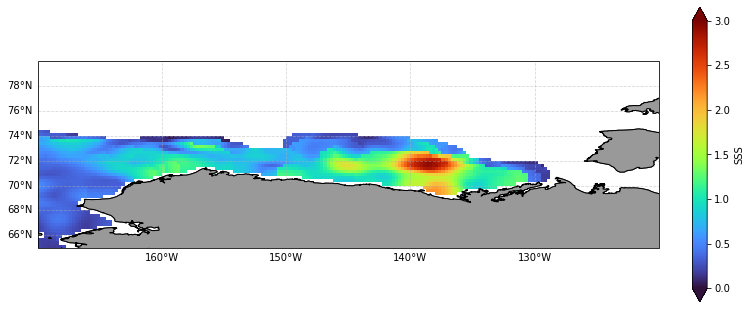

In [16]:
[LO,LA]=numpy.meshgrid(ds_stacked_sel.longitude,ds_stacked_sel.latitude)
fig = plt.figure()
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-150))  # Orthographic
extent = [lonmin, lonmax, latmin, latmax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
cs = ax.pcolormesh(LO,LA,ds_stacked_sel.sss.std(dim='time'),vmin=0,vmax=3,transform=ccrs.PlateCarree(),shading='auto')
cb = plt.colorbar(cs,fraction = 0.022,extend='both')
cb.set_label('SSS',fontsize = 10)